In [90]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import tensorflow as tf # For downloading images
from PIL import Image
import numpy as np

In [91]:
epochs = 100
batch_size_train = 128
batch_size_test = 128

myseed = 15
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [ ]:
# Download cats and dogs dataset
URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('/content/cats_and_dogs.zip', origin=URL, extract=True)
!unzip '/content/cats_and_dogs.zip'

train_path = '/content/cats_and_dogs_filtered/train'
test_path = '/content/cats_and_dogs_filtered/validation'

(500, 374)


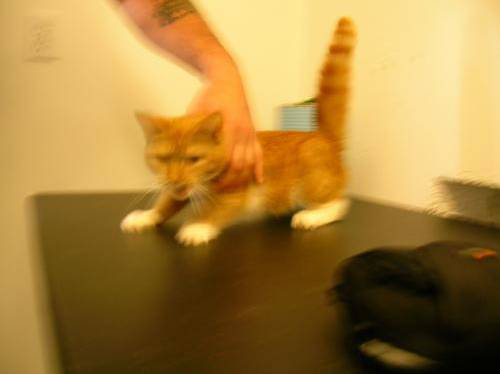

In [93]:
# Show image
img = Image.open('/content/cats_and_dogs_filtered/train/cats/cat.0.jpg')
print(img.size)
display(img)

In [94]:
image_transforms = transforms.Compose([transforms.Resize((256,256)),
                    transforms.RandomHorizontalFlip(0.5),
                    transforms.RandomRotation(degrees=15),
                    transforms.ColorJitter(brightness=0.5),
                    transforms.ToTensor()])

In [95]:
train_data = datasets.ImageFolder(train_path, transform=image_transforms)
test_data = datasets.ImageFolder(test_path, transform=image_transforms)

In [96]:
print(train_data.class_to_idx)

{'cats': 0, 'dogs': 1}


In [97]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test, shuffle=True)

In [98]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [99]:
example_data.shape

torch.Size([128, 3, 256, 256])

In [100]:
def get_label(label):
  if label == 0:
    return "Cat"
  return "Dog"

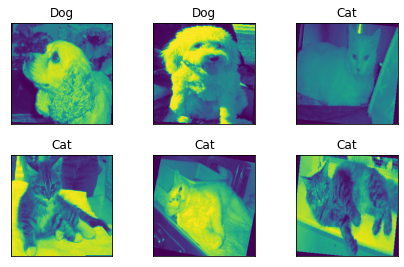

In [101]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0])
  plt.title("{}".format(get_label(example_targets[i])))
  plt.xticks([])
  plt.yticks([])

In [102]:
[list(train_data.class_to_idx.values()).index(0)]

[0]

In [103]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout(0.2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(0.2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(32*32*128, 256)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.dropout2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
       
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.dropout3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.dropout4(x)
        x = F.relu(x)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [104]:
network = Net()
network.cuda()
optimizer = torch.optim.RAdam(network.parameters(), lr=1e-4, weight_decay=5e-4)

In [105]:
train_losses = []
train_counter = []
test_accuracy = []
test_losses = []

best_epoch = 0
best_loss = 1000

In [106]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.cuda(), target.cuda()
    optimizer.zero_grad()
    pred = network(data)
    loss = F.binary_cross_entropy(pred.view(-1), target.float())
    loss.backward()
    optimizer.step()

  train_losses.append(loss.item())
  train_counter.append(epoch)

In [107]:
def test(epoch, best_epoch, best_loss):
  loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.cuda(), target.cuda()
      pred = network(data)
      pred = pred.view(-1)
      loss += F.binary_cross_entropy(pred, target.float(), reduction='sum').item()
      pred = torch.where(pred > 0.5, 1, 0)
      correct += torch.where(pred == target, 1, 0).sum()

  loss /= len(test_loader.dataset)
  if best_loss > loss:
    best_epoch, best_loss = epoch, loss
    torch.save(network.state_dict(), '/content/model.pth')
    torch.save(optimizer.state_dict(), '/content/optimizer.pth')
    print('Saving model (epoch = {:1d}, Loss = {:.4f}, Accuracy = {:.1f}%)'.format(epoch, loss, (100*correct/len(test_loader.dataset))))

  test_losses.append(loss)
  test_accuracy.append((100 * correct / len(test_loader.dataset)).item())
  return best_epoch, best_loss

In [108]:
for epoch in range(1, epochs+1):
  train(epoch)
  best_epoch, best_loss = test(epoch, best_epoch, best_loss)

Saving model (epoch = 1, Loss = 0.6915, Accuracy = 56.2%)
Saving model (epoch = 2, Loss = 0.6560, Accuracy = 60.9%)
Saving model (epoch = 3, Loss = 0.6336, Accuracy = 62.9%)
Saving model (epoch = 5, Loss = 0.6135, Accuracy = 66.2%)
Saving model (epoch = 6, Loss = 0.6088, Accuracy = 65.5%)
Saving model (epoch = 10, Loss = 0.6037, Accuracy = 67.7%)
Saving model (epoch = 11, Loss = 0.5996, Accuracy = 66.5%)
Saving model (epoch = 13, Loss = 0.5832, Accuracy = 68.5%)
Saving model (epoch = 14, Loss = 0.5717, Accuracy = 69.9%)
Saving model (epoch = 18, Loss = 0.5583, Accuracy = 70.4%)
Saving model (epoch = 23, Loss = 0.5530, Accuracy = 71.0%)
Saving model (epoch = 25, Loss = 0.5388, Accuracy = 73.1%)
Saving model (epoch = 35, Loss = 0.5356, Accuracy = 73.0%)
Saving model (epoch = 41, Loss = 0.5289, Accuracy = 74.2%)
Saving model (epoch = 43, Loss = 0.5088, Accuracy = 74.1%)
Saving model (epoch = 69, Loss = 0.4946, Accuracy = 77.4%)


Text(0, 0.5, 'Loss')

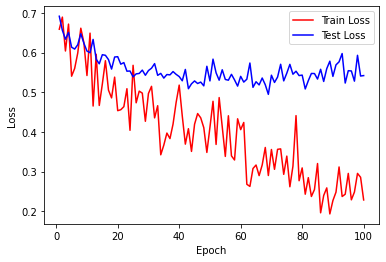

In [109]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(train_counter, train_losses, color='red')
plt.plot(train_counter, test_losses, color='blue')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

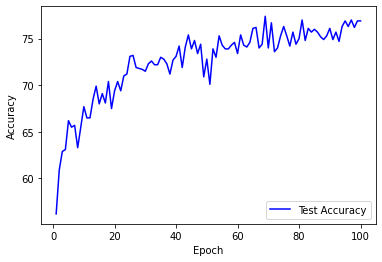

In [110]:
fig = plt.figure()
plt.plot(train_counter, test_accuracy, color='blue')
plt.legend(['Test Accuracy'], loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

#Predict

In [111]:
best_network = Net()
network_state_dict = torch.load('/content/model.pth')
best_network.load_state_dict(network_state_dict)

<All keys matched successfully>

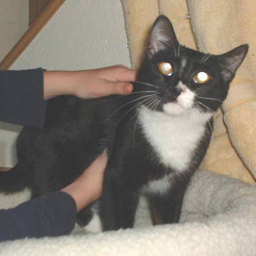

In [112]:
img = Image.open('/content/cats_and_dogs_filtered/validation/cats/cat.2000.jpg').resize((256, 256))
display(img)

In [114]:
img = img.resize((256, 256))
transform = transforms.ToTensor()
input = image_transforms(img)
input = torch.unsqueeze(input, 0)

In [115]:
best_network.eval()
output = best_network(input)

Cat


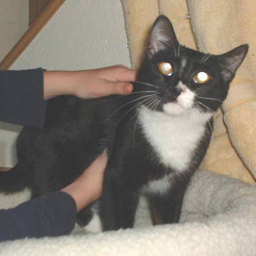

In [117]:
if output.item() < 0.5: # 0:Cat, 1:Dog 
  print("Cat")
else:
  print("Dog")

display(img)